# DCGAN on MNIST

In [1]:
import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt
import pandas as pd
import h5py

Using TensorFlow backend.


## Define Constants

In [2]:
img_rows = 64
img_cols = 64
img_channels = 1
batch_size = 64
epochs = 1000

## Discriminator Architecture

In [3]:
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (64,64,1)
D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape, padding='same'))
D.add(LeakyReLU(alpha=0.2))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
D.add(LeakyReLU(alpha=0.2))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
D.add(LeakyReLU(alpha=0.2))
D.add(Dropout(dropout))
D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
D.add(LeakyReLU(alpha=0.2))
D.add(Dropout(dropout))
D.add(Flatten())
D.add(Dense(1))
D.add(Activation('sigmoid'))
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         819456    
__________

## Generator Architecture

In [4]:
G = Sequential()
dropout = 0.4
depth = 64+64+64+64
dim = 16
G.add(Dense(dim*dim*depth, input_dim=100))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Dropout(dropout))
G.add(UpSampling2D())
G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
G.add(UpSampling2D())
G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
G.add(Conv2DTranspose(1, 5, padding='same'))
G.add(Activation('sigmoid'))
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
batch_normalization_1 (Batch (None, 65536)             262144    
_________________________________________________________________
activation_2 (Activation)    (None, 65536)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 256)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       819328    
__________

## Discriminator Model

In [5]:
optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Adversarial Model

In [6]:
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Load Data

In [7]:
X_train = pd.read_csv("../Data/lfw_grayscale_64.csv").iloc[:,1:].values.reshape(-1,64,64,1).astype("float32")/255

## Train DCGAN

In [ ]:
d_loss_seq = []
a_loss_seq = []
a_loss_avg = np.array([0.0,0.0])
d_loss_avg = np.array([0.0,0.0])
for i in range(epochs):
    images_train = X_train[np.random.randint(0, X_train.shape[0], size=batch_size), :, :, :]
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    images_fake = G.predict(noise)
    X = np.concatenate((images_train, images_fake))
    y = np.ones([2*batch_size, 1])
    y[batch_size:, :] = 0
    d_loss = DM.train_on_batch(X, y)
    y = np.ones([batch_size, 1])
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    a_loss = AM.train_on_batch(noise, y)
    a_loss_avg += a_loss
    d_loss_avg += d_loss
    if (i+1)%25==0:
        a_loss_avg/=25
        d_loss_avg/=25
        a_loss_seq.append(a_loss_avg)
        d_loss_seq.append(d_loss_avg)
        print("Epoch {}\tDiscriminator Loss: {}\tTotal Loss: {}".format(i+1,d_loss_avg,a_loss_avg))
        a_loss_avg = np.array([0.0,0.0])
        d_loss_avg = np.array([0.0,0.0])
        if (i+1)%100==0:
            G.save_weights("../Models/LFW_GRAYSCALE_64_DCGAN/G_epoch_{:04d}.hdf5".format(i+1))
            D.save_weights("../Models/LFW_GRAYSCALE_64_DCGAN/D_epoch_{:04d}.hdf5".format(i+1))

Epoch 25	Discriminator Loss: [ 7.20397343  0.495625  ]	Total Loss: [ 14.2664527   0.08     ]
Epoch 50	Discriminator Loss: [ 8.0590477  0.5      ]	Total Loss: [ 16.1180954   0.       ]
Epoch 75	Discriminator Loss: [ 8.0590477  0.5      ]	Total Loss: [ 16.1180954   0.       ]
Epoch 100	Discriminator Loss: [ 8.0590477  0.5      ]	Total Loss: [ 16.1180954   0.       ]
Epoch 125	Discriminator Loss: [ 8.0590477  0.5      ]	Total Loss: [ 16.1180954   0.       ]


## Check output

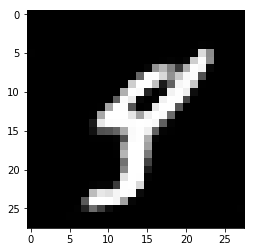

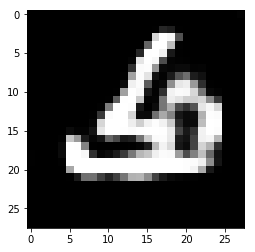

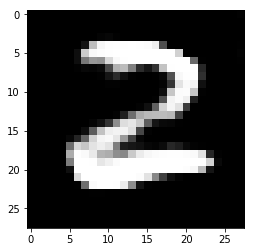

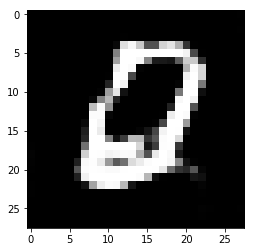

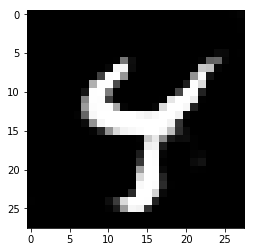

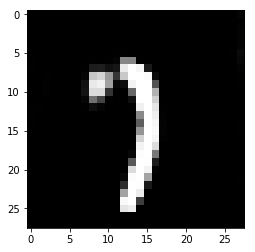

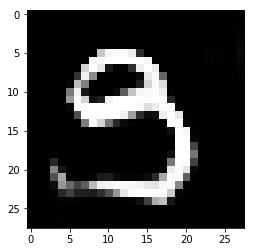

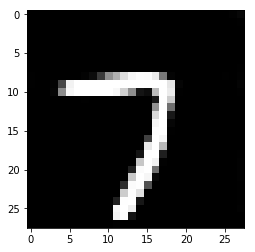

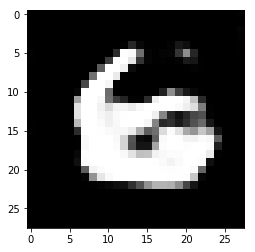

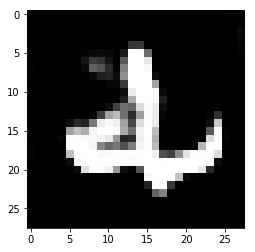

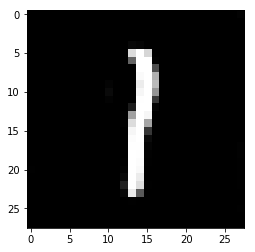

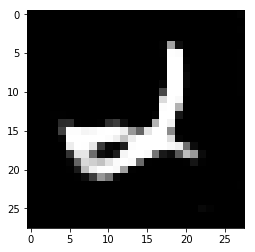

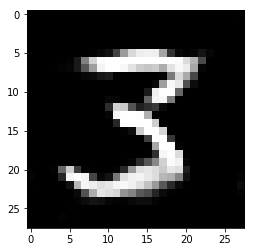

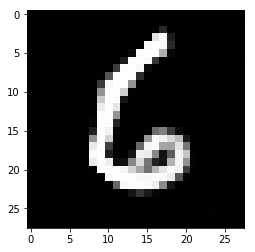

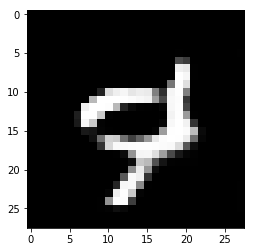

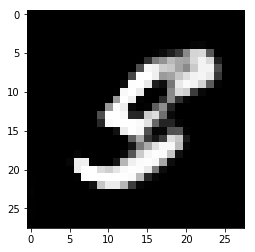

In [9]:
noise_input = np.random.uniform(-1.0,1.0, size=[16,100])
y_pred = G.predict(noise_input)
for i in y_pred:
    plt.imshow(i[:,:,0],cmap='gray')
    plt.show()

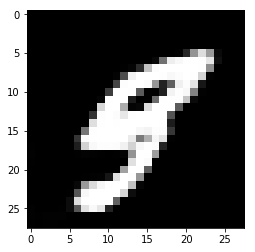

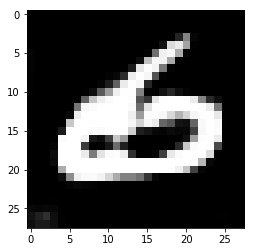

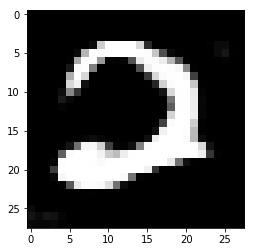

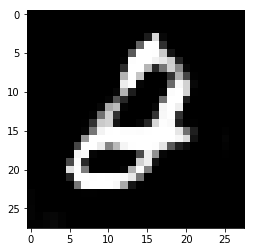

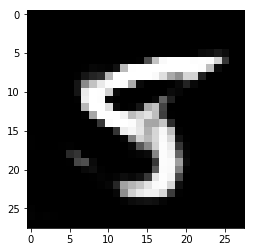

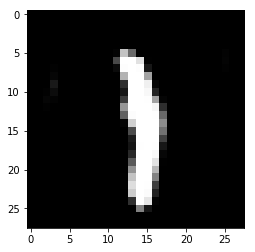

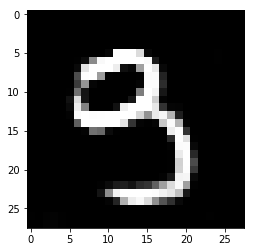

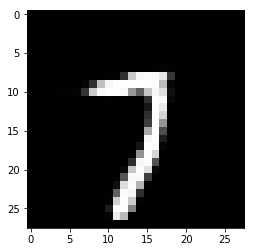

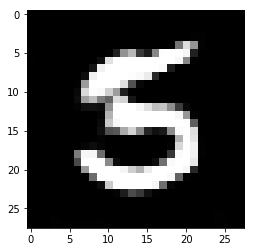

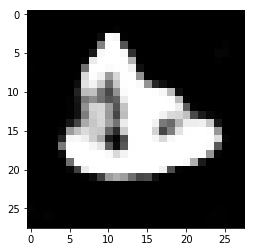

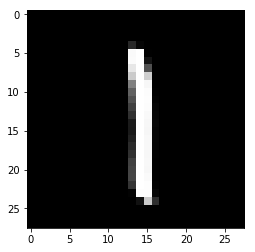

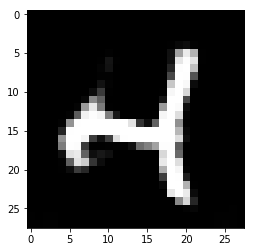

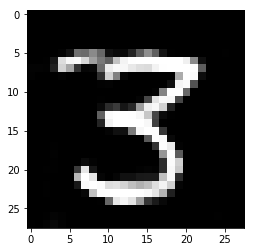

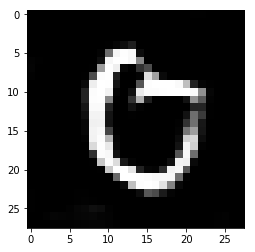

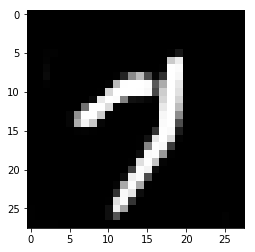

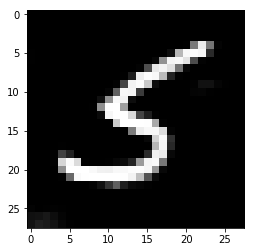

In [11]:
y_pred = G.predict(noise_input)
for i in y_pred:
    plt.imshow(i[:,:,0],cmap='gray')
    plt.show()

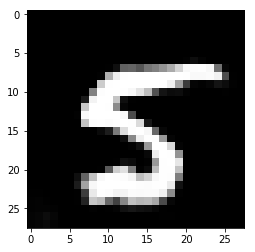

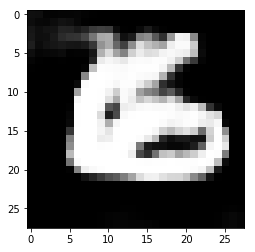

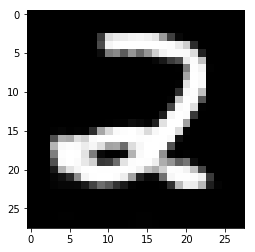

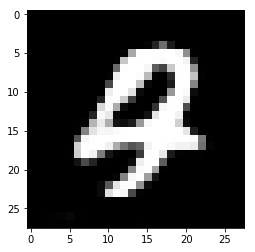

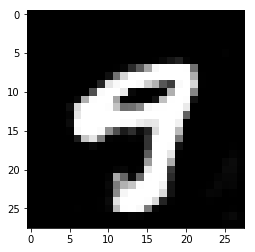

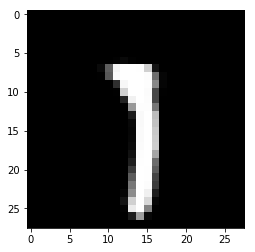

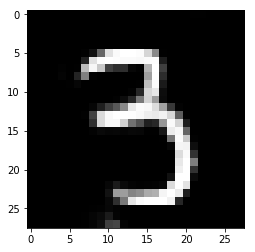

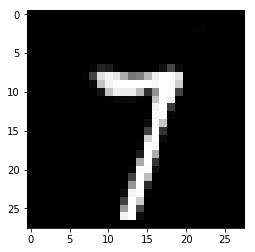

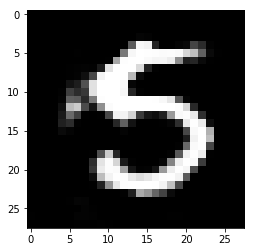

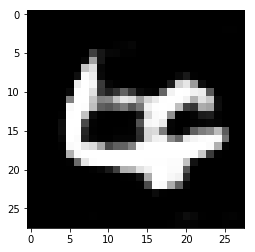

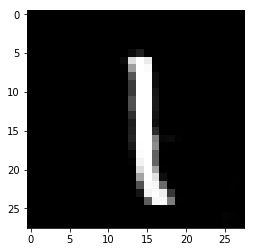

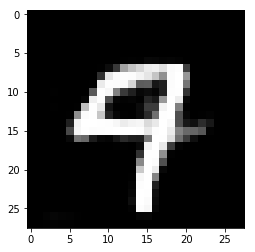

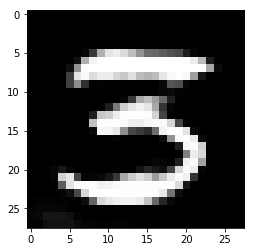

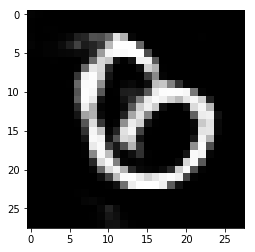

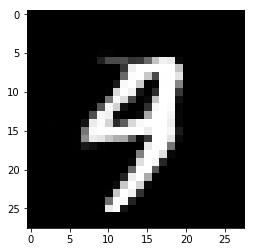

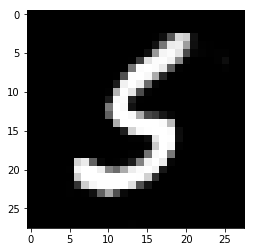

In [13]:
y_pred = G.predict(noise_input)
for i in y_pred:
    plt.imshow(i[:,:,0],cmap='gray')
    plt.show()